In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

In [2]:
#ee.Authenticate()
#geemap.update_package()

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

##Adding every plot coordinate
allplots_ga = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'
allplots_va= pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Coordinates and biomass/va_allpoints.csv')
allplots_va = allplots_va[allplots_va['liveMass'].notna()]
allplots_va = allplots_va[allplots_va['Latitude'].notna()]
allplots_va = allplots_va.drop(columns = ['deadMass', 'collectDate', 'totalMass', 'Ell', 'MSL', 'latitude', 'longitude'])
df_temp=allplots_va.copy()
df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size]
    }
)
df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N'
]
allplots_va = df_temp
s_patens = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPP-biomass.csv')
s_alterniflora = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Massachusetts/LTE-MP-LPA-biomass.csv')
s_patens['Latitude'] = 42.730953216553
s_patens['Longitude'] = -70.842918395996
s_alterniflora['Latitude'] = 42.731742858887
s_alterniflora['Longitude'] = -70.842468261719
s_patens.rename(columns={'LIVE biomass':'liveMass'}, inplace=True)
s_alterniflora.rename(columns={'MEAN BIOMASS':'liveMass'}, inplace=True)
df = pd.concat([s_patens, s_alterniflora])
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
dfx =  df.groupby(['SITE', 'Date'], as_index = False).aggregate(
    {
        'Longitude':[np.mean], 'Latitude':[np.mean], 'liveMass':[np.mean, np.size], 
        'MONTH':'first', 'YEAR':'first'
    }
) 
dfx.columns = [
    'Site','Date','Longitude','Latitude','liveMass', 'Sample size','Month', 'Year'
]

dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Latitude'] = 42.730953216553
dfx.loc[dfx['Site'] == 'LTE-MP-LPP', 'Longitude'] = -70.842918395996
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Latitude'] = 42.731742858887
dfx.loc[dfx['Site'] == 'LTE-MP-LPA', 'Longitude'] = -70.842468261719

fc_ma = geemap.pandas_to_ee(dfx, latitude = 'Latitude', longitude = 'Longitude')
fc_va = geemap.pandas_to_ee(allplots_va, latitude = "Latitude", longitude = "Longitude")
fc_ga = geemap.csv_to_ee(allplots_ga, latitude = "Latitude", longitude = "Longitude")

Map.addLayer(fc_ma, {}, "MA")
Map.addLayer(fc_va, {}, "VA")
Map.addLayer(fc_ga, {}, "GA")

# Map

In [3]:
yr_start = 2013
yr_end = 2013

ls_ma = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ma) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_va = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_va) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

ls_ga = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_ga) \
    .filter(ee.Filter.calendarRange(yr_start, yr_end,'year'))

In [4]:
# Apply scaling factors, cloud mask, and FLATS
def addFLATS(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(flats.rename('flats'))

def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

def addpheno(image):
    pheno = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

scaled_ma = ls_ma.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_va = ls_va.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)
scaled_ga = ls_ga.map(maskL8sr).map(addFLATS).map(maskFLATS).map(addpheno).map(addndvi).map(addevi).map(addnirv)

In [5]:
#https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion

#alternatively, ee.image sample? https://developers.google.com/earth-engine/api_docs#ee.image.sample

In [6]:
#LTER domains:
gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
vcr_clipdiss = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simpledissolve.shp'
pie_clipdiss = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simpledissolve.shp'

wet_ga = geemap.shp_to_ee(gce_clip)
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)
dissolve_va = geemap.shp_to_ee(vcr_clipdiss)
dissolve_ma = geemap.shp_to_ee(pie_clipdiss)

# ga_estuaries = ee.Geometry.MultiPolygon([
#     wet_ga1, wet_ga2, wet_ga3, wet_ga4, wet_ga5, wet_ga6, wet_ga7, wet_ga8, wet_ga9, wet_ga10, wet_ga11, wet_ga12
# ])

# wet_va = geemap.shp_to_ee(vcr_clip)
# wet_ma = geemap.shp_to_ee(pie_clip)

# clip_ga = scaled_ga.map(lambda image: image.clip(wet_ga))
# clip_0 = ee.Image(clip_ga.toList(clip_ga.size()).get(1)) ##Second image in collection

# Map.addLayer(clip_0, l8_param, 'Landsat 2020')
# Map.addLayer(ee.Image(scaled_ga.toList(scaled_ga.size()).get(0)), l8_param, '2020 Landsat 8 collection')
Map.addLayer(dissolve_ga, {}, 'GA estuaries')
Map.addLayer(dissolve_va, {}, 'VA estuaries')
Map.addLayer(dissolve_ma, {}, 'MA estuaries')

Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [7]:
#Pixel counts of each region:

image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')

x = image.reduceRegion(geometry=dissolve_ga, reducer=ee.Reducer.count(), scale=30)

x.getInfo()

{'QA_PIXEL': 227168,
 'QA_RADSAT': 227168,
 'SR_ATMOS_OPACITY': 227168,
 'SR_B1': 227168,
 'SR_B2': 227168,
 'SR_B3': 227168,
 'SR_B4': 227168,
 'SR_B5': 227168,
 'SR_B7': 227168,
 'SR_CLOUD_QA': 102835,
 'ST_ATRAN': 227168,
 'ST_B6': 227168,
 'ST_CDIST': 227168,
 'ST_DRAD': 227168,
 'ST_EMIS': 227168,
 'ST_EMSD': 227168,
 'ST_QA': 227168,
 'ST_TRAD': 227168,
 'ST_URAD': 227168}

In [8]:
#Time series of pheno band

#Add NIRV index! NIR*ndvi

out_dir = os.path.expanduser('~/Downloads')

out_ga = os.path.join(out_dir, 'evi_ga13.csv')
out_va = os.path.join(out_dir, 'evi_va13.csv')
out_ma = os.path.join(out_dir, 'evi_ma13.csv')

collection_ga = scaled_ga \
                  .select("evi")

collection_va = scaled_va \
                  .select("evi")

collection_ma = scaled_ma \
                  .select("evi")

# geemap.zonal_statistics(in_value_raster = collection_ga, in_zone_vector = dissolve_ga, \
#                 out_file_path = out_ga, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_va, in_zone_vector = dissolve_va, \
#                 out_file_path = out_va, statistics_type='MEAN', \
#                 scale = 30)

# geemap.zonal_statistics(in_value_raster = collection_ma, in_zone_vector = dissolve_ma, \
#                 out_file_path = out_ma, statistics_type='MEAN', \
#                 scale = 30)

In [23]:
#Read files, create time series
import glob
pathga = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/GA' #Dissolved vs. regions separately (in 'Old' folder) are different
pathva = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/VA' 
pathma = r'C:/Users/arj26323/Documents/Data/Phenology/EVI/MA'

all_files = glob.glob(pathga + "/*.csv")

li = []

for filename in all_files:
    df_ga = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ga)

df_ga = pd.concat(li, axis=1, ignore_index=False)

df_ga

all_files = glob.glob(pathva + "/*.csv")

li = []

for filename in all_files:
    df_va = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_va)

df_va = pd.concat(li, axis=1, ignore_index=False)

df_va

all_files = glob.glob(pathma + "/*.csv")

li = []

for filename in all_files:
    df_ma = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_ma)

df_ma = pd.concat(li, axis=1, ignore_index=False)

df_ma

,LC08_013030_20130330_nirv,LC08_012030_20130404_nirv,LC08_012030_20130409_nirv,LC08_012030_20130416_nirv,LC08_012030_20130502_nirv,LC08_012030_20130518_nirv,LC08_012030_20130603_nirv,LC08_012030_20130619_nirv,LC08_012030_20130705_nirv,LC08_012030_20130721_nirv,...,LC08_012030_20210812_nirv,LC08_012030_20210828_nirv,LC08_012030_20210913_nirv,LC08_012030_20210929_nirv,LC08_012030_20211015_nirv,LC08_012030_20211031_nirv,LC08_012030_20211116_nirv,LC08_012030_20211218_nirv,system:index,WETLAND_TY
0,0.054935,0.047496,0.049593,0.048659,0.052727,0.070619,NaN,0.147999,0.159323,NaN,...,0.167861,NaN,0.151547,0.138695,NaN,0.092467,0.0654,NaN,0,Estuarine and Marine Wetland


In [10]:
#Feesh
# for col in df_ga.columns:
#     print(col)

In [24]:
import datetime
dates_ga = df_ga.filter(regex='016038') ##Based on Landsat 8 image collection prefix! With GA, only getting one scene
dates_ga.columns = pd.to_datetime(dates_ga.columns.str.split('_').str[2])
dates_ga

dates_va = df_va.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_va.columns = pd.to_datetime(dates_va.columns.str.split('_').str[2])
dates_va

dates_ma = df_ma.filter(regex='LC') ##Based on Landsat 8 image collection prefix!
dates_ma.columns = pd.to_datetime(dates_ma.columns.str.split('_').str[2])
dates_ma

,2013-03-30,2013-04-04,2013-04-09,2013-04-16,2013-05-02,2013-05-18,2013-06-03,2013-06-19,2013-07-05,2013-07-21,...,2021-07-11,2021-07-27,2021-08-12,2021-08-28,2021-09-13,2021-09-29,2021-10-15,2021-10-31,2021-11-16,2021-12-18
0,0.054935,0.047496,0.049593,0.048659,0.052727,0.070619,NaN,0.147999,0.159323,NaN,...,0.163813,0.150815,0.167861,NaN,0.151547,0.138695,NaN,0.092467,0.0654,NaN


In [25]:
# mean_ma = dates_ma.mean()
# mean_va = dates_va.mean()
# mean_ga = dates_ga.mean()

# ga = pd.DataFrame(mean_ga, index = None, columns = ['EVI'])
# ga['Date'] = ga.index
# ga['LTER'] = 'GCE'

# va = pd.DataFrame(mean_ma, index = None, columns = ['EVI'])
# va['Date'] = va.index
# va['LTER'] = 'VCR'

# ma = pd.DataFrame(mean_va, index = None, columns = ['EVI'])
# ma['Date'] = ma.index
# ma['LTER'] = 'PIE'

ga = pd.DataFrame(dates_ga).T
ga['Date'] = ga.index
ga['LTER'] = 'GCE'
ga.rename(columns={0: 'EVI'}, inplace = True)

va = pd.DataFrame(dates_va).T
va['Date'] = va.index
va['LTER'] = 'VCR'
va.rename(columns={0: 'EVI'}, inplace = True)

ma = pd.DataFrame(dates_ma).T
ma['Date'] = ma.index
ma['LTER'] = 'PIE'
ma.rename(columns={0: 'EVI'}, inplace = True)

ga

df2 = pd.concat([ma, va, ga], axis = 0)

df2

,EVI,Date,LTER
2013-03-30,0.054935,2013-03-30,PIE
2013-04-04,0.047496,2013-04-04,PIE
2013-04-09,0.049593,2013-04-09,PIE
2013-04-16,0.048659,2013-04-16,PIE
2013-05-02,0.052727,2013-05-02,PIE
...,...,...,...
2021-10-27,0.045311,2021-10-27,GCE
2021-11-12,0.058147,2021-11-12,GCE
2021-11-28,NaN,2021-11-28,GCE
2021-12-14,0.047103,2021-12-14,GCE


In [26]:
xxx = ma[ma['Date'] < '2013-12-31']
xxx

,EVI,Date,LTER
2013-03-30,0.054935,2013-03-30,PIE
2013-04-04,0.047496,2013-04-04,PIE
2013-04-09,0.049593,2013-04-09,PIE
2013-04-16,0.048659,2013-04-16,PIE
2013-05-02,0.052727,2013-05-02,PIE
2013-05-18,0.070619,2013-05-18,PIE
2013-06-03,NaN,2013-06-03,PIE
2013-06-19,0.147999,2013-06-19,PIE
2013-07-05,0.159323,2013-07-05,PIE
2013-07-21,NaN,2013-07-21,PIE


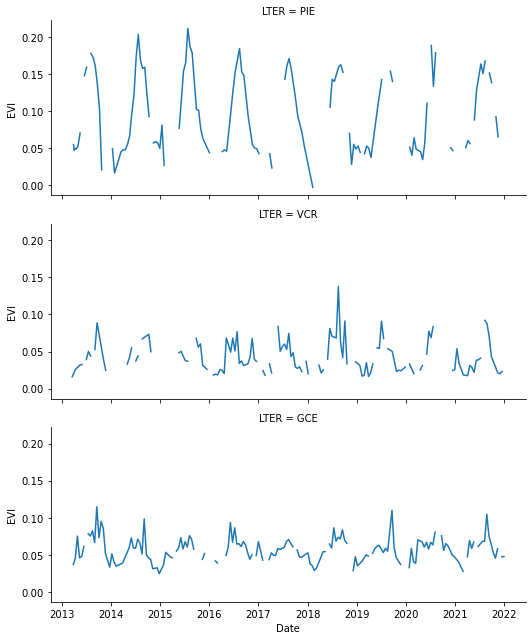

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

start_date = '2013-1-1'
end_date = '2021-12-31'

x1 = df2[(df2['Date'] > start_date) & (df2['Date'] <= end_date)]

dims = (11.7, 8.27)
# fig, ax = plt.subplots(figsize=dims)
# g = sns.lineplot(ax = ax, x = "Date", y = "NIRv_av", hue = 'LTER', data = x1)

g =  sns.FacetGrid(x1,col='LTER',col_wrap=1, aspect=2.5)
g.map_dataframe(plt.plot,'Date','EVI')

plt.show(g)

##Something very strange in Virginia in 2018 - Winter

#DAY OF GREENUP:
#2013: GCE: VCR: PIE:

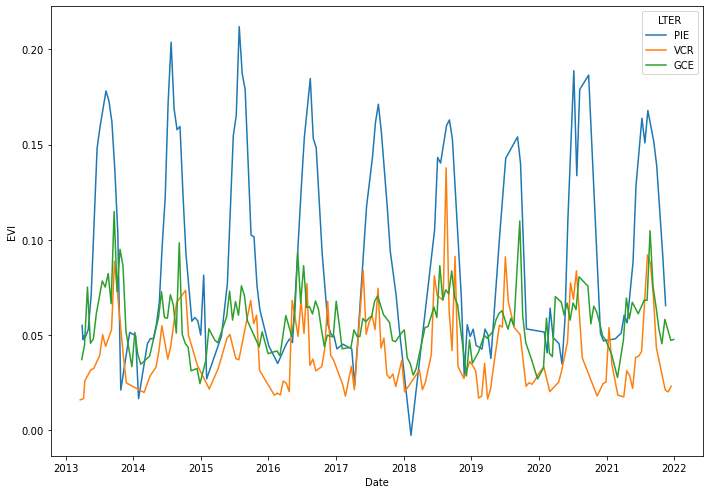

In [28]:
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "Date", y = "EVI", hue = 'LTER', data = x1)

,mean,sem,EVI,Month,LTER
Date,,,,,
1,0.044915,0.003573,0.044915,Jan,GCE
2,0.041738,0.003092,0.041738,Feb,GCE
3,0.042450,0.003136,0.042450,Mar,GCE
4,0.054997,0.003224,0.054997,Apr,GCE
5,0.056958,0.001601,0.056958,May,GCE
6,0.064761,0.002444,0.064761,Jun,GCE
7,0.067398,0.002381,0.067398,Jul,GCE
8,0.070471,0.003373,0.070471,Aug,GCE
9,0.075711,0.005197,0.075711,Sep,GCE


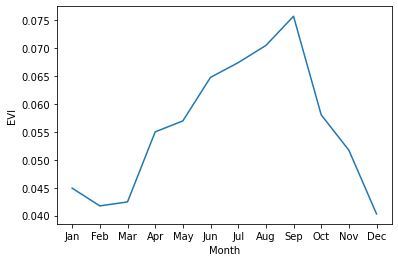

In [29]:
import calendar
gax = ga.groupby([ga.Date.dt.month])['EVI'].agg(['mean', 'sem'])
gax['EVI'] = gax['mean']
gax['Month'] = gax.index
gax['Month'] = gax['Month'].apply(lambda x: calendar.month_abbr[x])
gax['LTER'] = 'GCE'

sns.lineplot(x = "Month", y = "EVI", data = gax)
gax

<AxesSubplot:xlabel='Month', ylabel='EVI'>

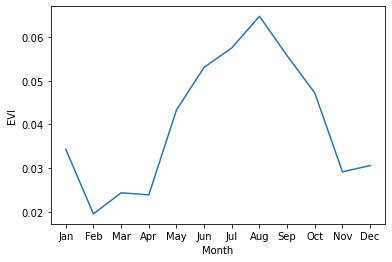

In [30]:
vax = va.groupby([va.Date.dt.month])['EVI'].agg(['mean', 'sem'])
vax['EVI'] = vax['mean']
vax['Month'] = vax.index
vax['Month'] = vax['Month'].apply(lambda x: calendar.month_abbr[x])
vax['LTER'] = 'VCR'

sns.lineplot(x = "Month", y = "EVI", data = vax)

<AxesSubplot:xlabel='Month', ylabel='EVI'>

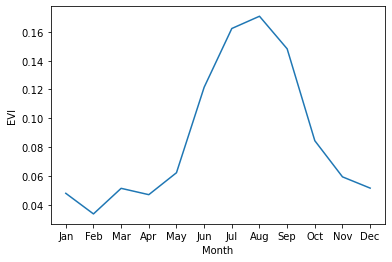

In [31]:
ma2 = ma.groupby([ma.Date.dt.month])['EVI'].agg(['mean', 'sem'])
ma2['EVI'] = ma2['mean']
ma2['Month'] = ma2.index
ma2['Month'] = ma2['Month'].apply(lambda x: calendar.month_abbr[x])
ma2['LTER'] = 'PIE'


sns.lineplot(x = "Month", y = "EVI", data = ma2)

ValueError: Could not interpret value `Month` for parameter `x`

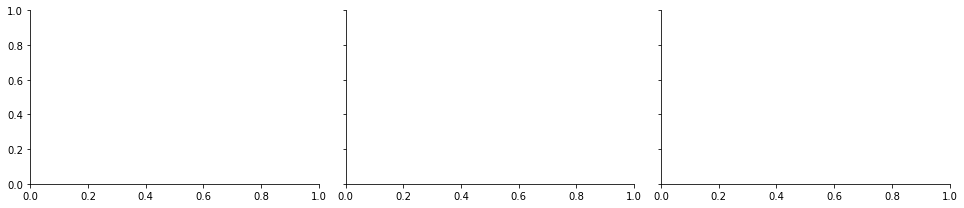

In [19]:
df3 = pd.concat([gax, vax, ma2])
df3

g = sns.FacetGrid(data=df3, col='LTER', aspect=1.5)
g.map(sns.lineplot(x ='Month', y = 'NIRv_av'))


In [ ]:
df3